<a href="https://colab.research.google.com/github/RxnAch/DeepLearning/blob/main/Model_Selection_%2C_Underfitting_%2COverfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l

In [3]:
import math
import numpy as np
import torch 
from torch import nn
from d2l import torch as d2l

 **Generating the Dataset**

 

In [12]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [ ]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

**Training and Testing the Model**

Let us first implement a function to evaluate the loss on a given dataset.

In [21]:
def evaluate_loss(net,data_iter,loss):
  metric = d2l.Accumulator(2)
  for X,y in data_iter:
    out = net(X)
    y = y.reshape(out.shape)
    l = loss(out,y)
    metric.add(l.sum(),l.numel())
  return metric[0]/metric[1]

**Now define the training function.**

In [41]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

**Third-Order Polynomial Function Fitting(Normal)**

weight: [[ 5.0159225  1.2158583 -3.421849   5.550292 ]]


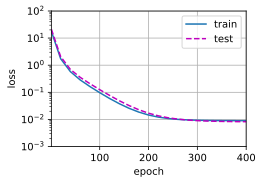

In [40]:
train(poly_features[:n_train,:4],poly_features[n_train:,:4],
      labels[:n_train],labels[n_train:])

**Linear Function Fitting(Underfitting)**

weight: [[3.3197763 3.4644156]]


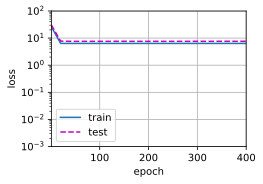

In [33]:
train(poly_features[:n_train,:2],poly_features[n_train:,:2],
      labels[:n_train],labels[n_train:])

**High-Order Polynomial Function Fitting(overfitting)**

weight: [[ 5.0048165   1.295349   -3.3638875   5.1229224  -0.18802616  1.31133
   0.06306466 -0.01120993 -0.18111017 -0.18846932 -0.10464184  0.21635653
  -0.19751307  0.04768196 -0.08733537 -0.04442978  0.19146372  0.06045836
  -0.18511635 -0.13262686]]


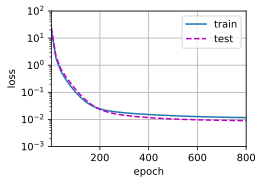

In [38]:
train(poly_features[:n_train,:],poly_features[n_train:,:],
      labels[:n_train],labels[n_train:],num_epochs = 800)